In [388]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression,Ridge
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
from patsy import dmatrix
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from math import sqrt

In [389]:
data = pd.read_csv('data/Wage.csv')

In [390]:
X = pd.DataFrame(data['age'],columns =['age'])
y = data['wage']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state =42,test_size =0.2)

Cross val Loss is -1599.5982
Cross val Loss is -1594.7262
Cross val Loss is -1593.9141
Cross val Loss is -1595.4331
Cross val Loss is -1594.9302


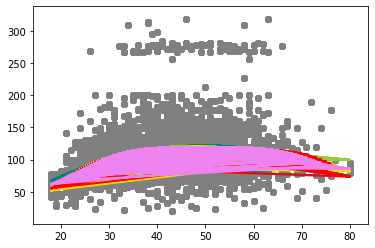

In [376]:
colors = ['teal', 'yellowgreen', 'gold','red','violet']
x_plot = X['age']
for count, degree in enumerate([2,3,4,5,6]):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X, y)
    y_pred = model.predict(X)
    print(f"Cross val Loss is {cross_val_score(model,X,y,cv=5,scoring='neg_mean_squared_error').mean():.4f}")
    plt.scatter(x_plot,y,color='grey')
    plt.plot(x_plot,y_pred,color=colors[count], linewidth=2,
             label="degree %d" % degree)

In [377]:
poly = PolynomialFeatures(4)
model = LinearRegression()
X_transform = poly.fit_transform(X_train)
model.fit(X_transform,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [378]:
cross_val_score(model,X_transform,y_train,cv=5,scoring='neg_mean_squared_error').mean()

-1638.90661074761

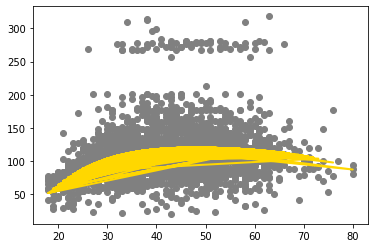

In [379]:
y_pred = model.predict(poly.transform(X_test))
plt.scatter(X_train,y_train,color ='grey')
plt.plot(X_test,y_pred,linewidth =2, color ='gold')

In [380]:
df_cut, bins = pd.cut(X_train['age'], 4, retbins=True, right=True)
df_cut.value_counts(sort=False)

(17.938, 33.5]     610
(33.5, 49.0]      1115
(49.0, 64.5]       624
(64.5, 80.0]        51
Name: age, dtype: int64

In [381]:
df_steps = pd.concat([X_train, df_cut, y_train], keys=['age','age_cuts','wage'], axis=1)
df_steps_dummies = pd.get_dummies(df_cut)
df_steps_dummies.head()

,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
642,0,0,1,0
700,0,1,0,0
226,1,0,0,0
1697,0,0,1,0
1010,0,1,0,0


In [382]:
stepwise = sm.GLM(df_steps.wage, df_steps_dummies).fit()

In [383]:
bin_mapping = np.digitize(X_test, bins)
X_test_bin = pd.get_dummies(bin_mapping.reshape(bin_mapping.shape[0])).drop([5], axis=1)
pred = stepwise.predict(X_test_bin)

38.336953115739426


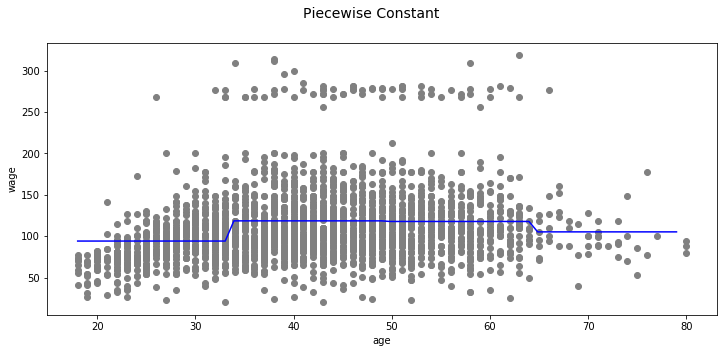

In [387]:
xp = np.linspace(X_test.min(),X_test.max()-1,70) 
bin_mapping = np.digitize(xp, bins) 
X_valid_2 = pd.get_dummies(bin_mapping.reshape(bin_mapping.shape[0]))
pred2 = stepwise.predict(X_valid_2)
fig, (ax1) = plt.subplots(1,1, figsize=(12,5))
fig.suptitle('Piecewise Constant', fontsize=14)
ax1.scatter(X_train['age'],y_train,color ='grey')
ax1.plot(xp,pred2, color ='b')
ax1.set_xlabel('age')
ax1.set_ylabel('wage')
print(sqrt(mean_squared_error(y_test,stepwise.predict(X_test_bin))))

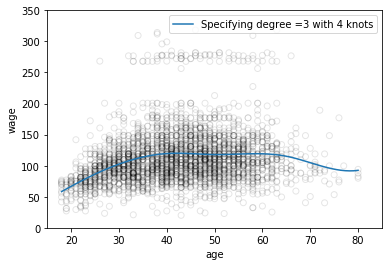

37.85943238902224


In [385]:
transformed_x = dmatrix("bs(train, knots=(25,40,50,65), degree=3, include_intercept=False)", {"train": X_train},return_type='dataframe')
cubic_spline = sm.GLM(y_train, transformed_x).fit()
xp = np.linspace(X_test.min(),X_test.max(),70)
pred = cubic_spline.predict(dmatrix("bs(valid, knots=(25,40,50,65), include_intercept=False)", {"valid": xp}, return_type='dataframe'))
plt.scatter(data.age, data.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred, label='Specifying degree =3 with 4 knots')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')
plt.show()
print(sqrt(mean_squared_error(y_test, cubic_spline.predict(dmatrix("bs(valid, knots=(25,40,50,65), include_intercept=False)", {"valid": X_test}, return_type='dataframe')))))

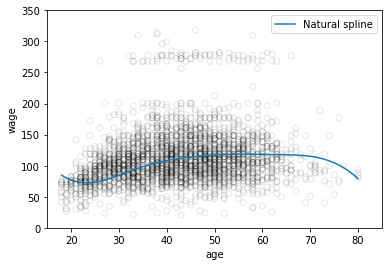

38.51179390079552


In [386]:
transformed_x = dmatrix("cr(train, df=6)", {"train": X_train},return_type='dataframe')
cubic_spline = sm.GLM(y_train, transformed_x).fit()
xp = np.linspace(X_test.min(),X_test.max(),70)
pred = cubic_spline.predict(dmatrix("bs(valid, df=6)", {"valid": xp}, return_type='dataframe'))
plt.scatter(data.age, data.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred, label='Natural spline')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')
plt.show()
print(sqrt(mean_squared_error(y_test, cubic_spline.predict(dmatrix("bs(valid, df=6)", {"valid": X_test}, return_type='dataframe')))))